#Importando pacotes

In [ ]:
pip install git+https://github.com/statsmodels/statsmodels.git

  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-dgdajcom
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-dgdajcom
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+619.g5c3f9b34e-cp37-cp37m-linux_x86_64.whl size=17670973 sha256=52e04f0cdd931b9269dfa56138c7bf4adc2c794876c312b39ecb9e3768d5d3cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbgb2fx9/wheels/5c/ab/d8/d9505a18dd992621edd24cfddb9a1bd694dee85c065c0a6e57
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from sklearn.metrics import mean_squared_error
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

#Importando os dados

In [ ]:
dados = pd.read_excel('Teste_USP.xlsx')

In [ ]:
dados.head()

,Date,Trucks,IBCBR,Corrente de Comércio,Confiança,IPCA,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF
0,2003-01-01,4960.406782,100.48,34250.018637,97.8,2.20,384508.0,24967.907646,101.45,22,25.5,47.2,79.8,80.6,NaN,111.356,107.580547
1,2003-02-01,6247.814356,102.01,36024.354730,96.0,1.55,388320.0,25073.179942,109.05,20,26.5,48.0,79.7,80.3,NaN,114.589,105.382185
2,2003-03-01,5199.720503,101.76,35491.787728,93.1,1.22,386969.0,24800.866571,100.18,20,26.5,46.6,79.8,80.1,NaN,109.121,98.641268
3,2003-04-01,5416.424894,100.95,34301.013803,91.1,0.94,383307.0,24512.253853,90.84,20,26.5,46.6,79.5,79.9,NaN,96.720,101.280944
4,2003-05-01,5637.510125,99.79,38008.220507,88.9,0.65,386300.0,25033.870618,87.33,21,26.5,46.3,77.8,79.2,NaN,92.504,97.286746


#Substituindo os "NANS" pela media dos valores de cada coluna


In [ ]:
# convertemos para o formato Numpy e ignoramos a última coluna (classe)
X = np.array(dados[dados.columns[1:dados.shape[1]]], dtype = float) 
# calculamos a média de cada atributo e armazenamos em um vetor
# Usamos a função nanmean que calcula a média ignorando os Nan
averages = np.nanmean(X, axis = 0) # veja https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmean.html
for i in np.arange(0, X.shape[0]):
    for j in np.arange(0, X.shape[1]):
        if(np.isnan(X[i,j]) == True): # verificar se é uma entrada com Nan
            X[i,j] = averages[j] # insere a média
print(X)

[[4.96040678e+03 1.00480000e+02 3.42500186e+04 ... 8.57569620e+01
  1.11356000e+02 1.07580547e+02]
 [6.24781436e+03 1.02010000e+02 3.60243547e+04 ... 8.57569620e+01
  1.14589000e+02 1.05382185e+02]
 [5.19972050e+03 1.01760000e+02 3.54917877e+04 ... 8.57569620e+01
  1.09121000e+02 9.86412681e+01]
 ...
 [1.17685466e+04 1.39110000e+02 7.65262569e+04 ... 8.34000000e+01
  6.06050000e+01 1.48802389e+02]
 [1.12040587e+04 1.30508190e+02 7.79774700e+04 ... 8.76000000e+01
  5.80570000e+01 1.48802389e+02]
 [8.53507890e+03 1.30508190e+02 5.63884912e+04 ... 8.92000000e+01
  5.90350000e+01 1.48802389e+02]]


In [ ]:
lista = list(dados.drop_duplicates())
lista = lista[1:17]
data = pd.DataFrame(X)
data.columns = lista

In [ ]:
data['Date']= dados['Date']
lista2 = list(dados.drop_duplicates())
data = data[lista2]
data.index = pd.to_datetime(data.Date)
data.drop(columns= ['Date'], inplace=True)


In [ ]:
x = []
y = data['IPCA'].dropna()
for i in data['IPCA']:
  x.append(i)

In [ ]:
sum = 0
tamanho = 0
for i in x:
  sum += i
  tamanho +=1
  media = sum / tamanho 


In [ ]:
media

0.46990990990991

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223 entries, 2003-01-01 to 2021-07-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Trucks                223 non-null    float64
 1   IBCBR                 223 non-null    float64
 2   Corrente de Comércio  223 non-null    float64
 3   Confiança             223 non-null    float64
 4   IPCA                  223 non-null    float64
 5   Credito               223 non-null    float64
 6   Consumo de Energia    223 non-null    float64
 7   IC                    223 non-null    float64
 8   du                    223 non-null    float64
 9   Selic                 223 non-null    float64
 10  PMC                   223 non-null    float64
 11  PIM                   223 non-null    float64
 12  NUCI                  223 non-null    float64
 13  IAE                   223 non-null    float64
 14  E                     223 non-null    float64
 15  FBKF

In [ ]:
#data.index = pd.to_datetime(data.Date)

#Transformação logarítmica dos dados

In [ ]:
data[lista] = data[lista].apply(lambda x: np.log(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
x = data['IPCA']
data = data.drop(['IPCA'], axis =1)


In [ ]:
ipca = []
for i in x:
  ipca.append(np.log(i))

data['IPCA'] = ipca

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223 entries, 2003-01-01 to 2021-07-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Trucks                223 non-null    float64
 1   IBCBR                 223 non-null    float64
 2   Corrente de Comércio  223 non-null    float64
 3   Confiança             223 non-null    float64
 4   Credito               223 non-null    float64
 5   Consumo de Energia    223 non-null    float64
 6   IC                    223 non-null    float64
 7   du                    223 non-null    float64
 8   Selic                 223 non-null    float64
 9   PMC                   223 non-null    float64
 10  PIM                   223 non-null    float64
 11  NUCI                  223 non-null    float64
 12  IAE                   223 non-null    float64
 13  E                     223 non-null    float64
 14  FBKF                  223 non-null    float64
 15  IPCA

In [ ]:
data

,Trucks,IBCBR,Corrente de Comércio,Confiança,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF,IPCA
Date,,,,,,,,,,,,,,,,
2003-01-01,8.509243,4.609959,10.441442,4.582925,12.859720,10.125347,4.619566,3.091042,3.238678,3.854394,4.379524,4.389499,4.451517,4.712732,4.678240,-0.237677
2003-02-01,8.739987,4.625071,10.491951,4.564348,12.869585,10.129554,4.691806,2.995732,3.277145,3.871201,4.378270,4.385770,4.451517,4.741352,4.657594,-0.824955
2003-03-01,8.556360,4.622617,10.477057,4.533674,12.866100,10.118634,4.606969,2.995732,3.277145,3.841601,4.379524,4.383276,4.451517,4.692457,4.591490,-1.615200
2003-04-01,8.597191,4.614625,10.442930,4.511958,12.856592,10.106928,4.509100,2.995732,3.277145,3.841601,4.375757,4.380776,4.451517,4.571820,4.617898,NaN
2003-05-01,8.637198,4.603068,10.545558,4.487512,12.864370,10.127985,4.469694,3.044522,3.277145,3.835142,4.354141,4.371976,4.451517,4.527252,4.577663,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,9.224006,4.931087,11.239218,4.448516,15.227832,10.649545,5.793684,3.135494,1.011601,4.558079,4.472781,4.360548,4.345103,4.225110,5.155246,NaN
2021-04-01,9.197865,4.939569,11.256319,4.490881,15.233178,10.633169,5.805737,2.995732,1.011601,4.606170,4.457830,4.339902,4.365643,4.194688,4.956780,NaN
2021-05-01,9.373186,4.935265,11.245389,4.548600,15.244912,10.616003,5.816724,3.044522,1.252763,4.620059,4.471639,4.354141,4.423648,4.104377,5.002619,NaN


In [ ]:
data.fillna(media, inplace=True)


In [ ]:
data1 = data
data = data.query('Date <"2020-07-01"')

In [ ]:
data

,Trucks,IBCBR,Corrente de Comércio,Confiança,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF,IPCA
Date,,,,,,,,,,,,,,,,
2003-01-01,8.509243,4.609959,10.441442,4.582925,12.859720,10.125347,4.619566,3.091042,3.238678,3.854394,4.379524,4.389499,4.451517,4.712732,4.678240,-0.237677
2003-02-01,8.739987,4.625071,10.491951,4.564348,12.869585,10.129554,4.691806,2.995732,3.277145,3.871201,4.378270,4.385770,4.451517,4.741352,4.657594,-0.824955
2003-03-01,8.556360,4.622617,10.477057,4.533674,12.866100,10.118634,4.606969,2.995732,3.277145,3.841601,4.379524,4.383276,4.451517,4.692457,4.591490,-1.615200
2003-04-01,8.597191,4.614625,10.442930,4.511958,12.856592,10.106928,4.509100,2.995732,3.277145,3.841601,4.375757,4.380776,4.451517,4.571820,4.617898,0.469910
2003-05-01,8.637198,4.603068,10.545558,4.487512,12.864370,10.127985,4.469694,3.044522,3.277145,3.835142,4.354141,4.371976,4.451517,4.527252,4.577663,0.469910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,8.995845,4.937634,11.126971,4.562263,15.064247,10.603567,5.330881,2.944439,1.446919,4.581902,4.471639,4.333361,4.521789,4.295093,5.045572,0.469910
2020-03-01,8.748371,4.888091,11.132401,4.495355,15.092273,10.588733,5.286852,3.091042,1.321756,4.555980,4.390739,4.321480,4.414010,4.384237,4.933738,0.469910
2020-04-01,8.291232,4.788241,11.176682,4.014580,15.092275,10.509029,5.302359,2.995732,1.321756,4.375757,4.178992,4.048301,3.681351,4.424212,4.626381,0.469910


#ARIMAX 

##Preparando os dados

In [ ]:
y = data['Trucks']
y


Date
2003-01-01    8.509243
2003-02-01    8.739987
2003-03-01    8.556360
2003-04-01    8.597191
2003-05-01    8.637198
                ...   
2020-02-01    8.995845
2020-03-01    8.748371
2020-04-01    8.291232
2020-05-01    8.503330
2020-06-01    9.084983
Name: Trucks, Length: 210, dtype: float64

In [ ]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [ ]:
exog = data['IBCBR']
import statsmodels.api as sm
aic_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y,
                                       order=param,
                                       seasonal_order=param_seasonal, exog = exog)
        results = mod.fit()
        aic_list.append('ARIMA{}x{} - AIC{} - P.VALOR {}'.format(param, param_seasonal, results.aic, results.pvalues))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

In [ ]:
aic_list


['ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC158.29519437946232 - P.VALOR IBCBR     0.000000e+00\nsigma2    1.289146e-14\ndtype: float64',
 'ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC1.9500194821069101 - P.VALOR IBCBR       0.000000e+00\nma.S.L12    1.005296e-39\nsigma2      3.777062e-26\ndtype: float64',
 'ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC-24.50361912896139 - P.VALOR IBCBR     5.013494e-25\nsigma2    9.161249e-22\ndtype: float64',
 'ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC-38.53756972173352 - P.VALOR IBCBR       7.952893e-26\nma.S.L12    1.574406e-06\nsigma2      4.479783e-25\ndtype: float64',
 'ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC3.703331567217525 - P.VALOR IBCBR       0.000000e+00\nar.S.L12    2.668349e-51\nsigma2      3.646163e-19\ndtype: float64',
 'ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC-27.784112478545808 - P.VALOR IBCBR       0.000000e+00\nar.S.L12    1.351610e-10\nma.S.L12    8.483458e-19\nsigma2      3.111746e-32\ndtype: float64',
 'ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC-37.341010354013605 - P.VALOR IBCBR   

##MODELO

In [ ]:
data.corr()

,Trucks,IBCBR,Corrente de Comércio,Confiança,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF,IPCA
Trucks,1.000000,0.434102,0.021655,0.631318,0.073159,0.171967,-0.296812,0.068942,-0.253067,0.249658,0.810348,0.636620,0.102825,-0.695549,0.672212,0.111479
IBCBR,0.434102,1.000000,0.821273,-0.080477,0.896465,0.940011,0.540042,0.003529,-0.634729,0.961423,0.559856,-0.072083,0.064866,-0.678918,0.921172,-0.012546
Corrente de Comércio,0.021655,0.821273,1.000000,-0.343250,0.918474,0.917861,0.800882,-0.022200,-0.678920,0.886122,0.128190,-0.460450,0.024407,-0.309793,0.610019,-0.047094
Confiança,0.631318,-0.080477,-0.343250,1.000000,-0.428799,-0.299422,-0.571052,0.034917,0.029348,-0.286941,0.618757,0.817925,0.615585,-0.420453,0.129014,0.158747
Credito,0.073159,0.896465,0.918474,-0.428799,1.000000,0.979728,0.810711,-0.011412,-0.707601,0.977202,0.144164,-0.487825,-0.061023,-0.362897,0.707141,-0.062285
Consumo de Energia,0.171967,0.940011,0.917861,-0.299422,0.979728,1.000000,0.765850,-0.000760,-0.700045,0.983624,0.277146,-0.353942,0.023473,-0.445710,0.768957,-0.040354
IC,-0.296812,0.540042,0.800882,-0.571052,0.810711,0.765850,1.000000,-0.032660,-0.600179,0.711898,-0.306547,-0.718065,-0.084218,0.168621,0.279892,-0.147414
du,0.068942,0.003529,-0.022200,0.034917,-0.011412,-0.000760,-0.032660,1.000000,0.034744,-0.001703,0.050501,0.048154,0.020695,-0.009279,0.080604,0.070175
Selic,-0.253067,-0.634729,-0.678920,0.029348,-0.707601,-0.700045,-0.600179,0.034744,1.000000,-0.697616,-0.106431,0.385119,-0.025761,0.285418,-0.518192,-0.037627
PMC,0.249658,0.961423,0.886122,-0.286941,0.977202,0.983624,0.711898,-0.001703,-0.697616,1.000000,0.324631,-0.313488,-0.018031,-0.493113,0.827376,-0.046382


Usando a pesquisa de correlação e fazendo alguns testes, identificamos o conjunto de parâmetros que produzirá o modelo de melhor ajuste para nossos dados de série temporal. Podemos prosseguir para analisar este modelo específico com mais profundidade.


In [ ]:
exorg = data['IBCBR']

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order = (1,0,1,12), exog=exorg)
results = mod.fit()



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:584: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Trucks   No. Observations:                  210
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 208.265
Date:                            Tue, 17 Aug 2021   AIC                           -404.529
Time:                                    17:07:28   BIC                           -384.475
Sample:                                01-01-2003   HQIC                          -396.421
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IBCBR          4.3589      0.509      8.564      0.000       3.361       5.357
ar.L1          0.4553      0.217   

results.summary resulta na saída de SARIMAX que retorna uma quantidade significativa de informações, mas vamos concentrar nossa atenção na tabela de coeficientes. A coluna de coeficiente mostra o peso (ou seja, importância) de cada recurso e como cada um impacta a série temporal. O P> | z | nos informa sobre a importância de cada peso. Aqui, cada peso tem um valor p inferior ou próximo a 0,05, portanto, é melhor mante-los em nosso modelo.

O Ljung-Box nos ajuda a determinar se os erros residuais da regressão são autocorrelacionados de forma estatisticamente significativa. Nesse caso, o valor de p é 0,88, o que é significativamente maior do que 0,05 (limite de confiança de 95%). Portanto, aceitamos a hipótese nula do teste Ljung-Box de que os erros residuais não são autocorrelacionados.

**O** **teste** **Ljung-Box** **pode** **ser** **definido** **como:**

H0: Os dados são distribuídos de forma independente (ou seja, as correlações na população da qual a amostra é retirada são 0, de modo que quaisquer correlações observadas nos dados resultam da aleatoriedade do processo de amostragem).

Ha: Os dados não são distribuídos de forma independente; eles exibem correlação serial.


##Sumário

Ao ajustar modelos ARIMA sazonais é importante executar o diagnóstico do modelo para garantir que nenhuma das suposições feitas pelo modelo foi violada. O objeto plot_diagnostics nos permite gerar diagnósticos de modelo rapidamente e investigar qualquer comportamento incomum.

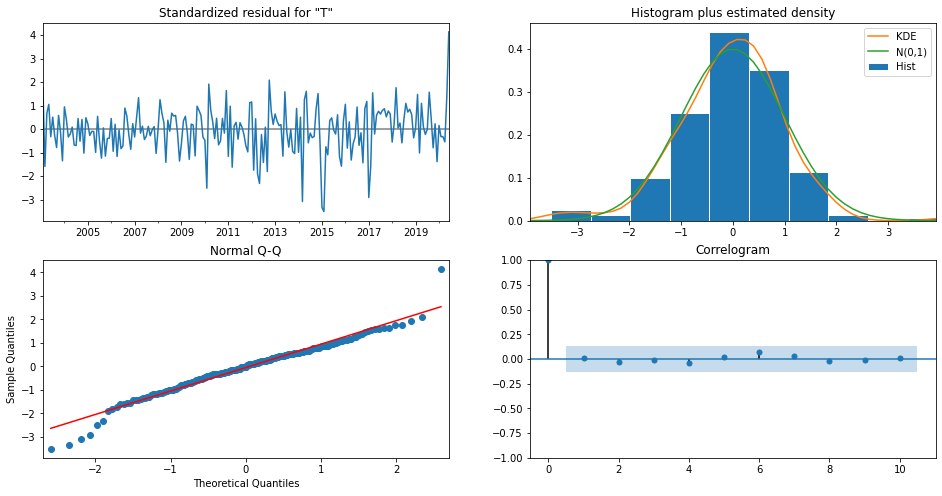

In [ ]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

Nossa principal preocupação é garantir que os resíduos de nosso modelo não estejam correlacionados e sejam normalmente distribuídos com média zero. Se o modelo ARIMA sazonal não satisfizer essas propriedades, é uma boa indicação de que pode ser melhorado.

Neste caso, nosso diagnóstico do modelo sugere que os resíduos são normalmente distribuídos com base no seguinte:

No gráfico superior direito, vemos que a linha laranja do KDE segue de perto a linha N (0,1) (onde N (0,1)) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1) . Esta é uma boa indicação de que os resíduos estão normalmente distribuídos.

O gráfico na parte inferior esquerda mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras obtidas de uma distribuição normal padrão com N (0, 1), tendo apenas um leve desvio no inicio e no fim , isto é uma indicação de que os resíduos são normalmente distribuídos.
Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco (Aleatoriamente distribuidos), isso é confirmado pelo gráfico de autocorrelação (correlogram) na parte inferior direita, que mostra que os resíduos da série temporal têm baixa correlação com as versões defasadas de si mesmos.
Essas observações nos levam a concluir que nosso modelo produz um ajuste satisfatório que pode nos ajudar a entender nossos dados de série temporal e prever valores futuros.


##Previsões

Obtivemos um modelo para nossas séries temporais que agora pode ser usado para produzir previsões.


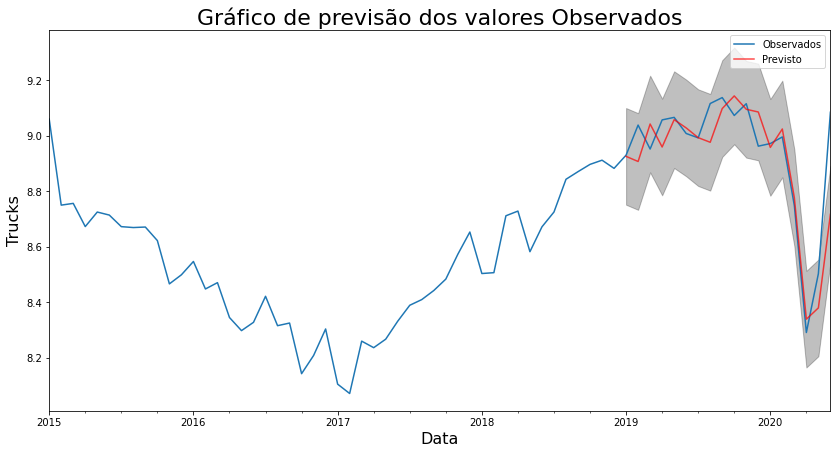

In [ ]:
plt.figure(figsize=(14,7))
plt.title('Gráfico de previsão dos valores Observados', fontsize = 22)
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='Observados')
pred.predicted_mean.plot(ax=ax, label='Previsto', color='r', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k',alpha=0.25)
plt.legend()
ax.set_xlabel('Data',fontsize=16)
ax.set_ylabel('Trucks',fontsize=16)
plt.show()

In [ ]:
data2 = data1.query('Date > "2020-07-01"')
exog = data2['IBCBR']

Text(0, 0.5, 'Trucks')

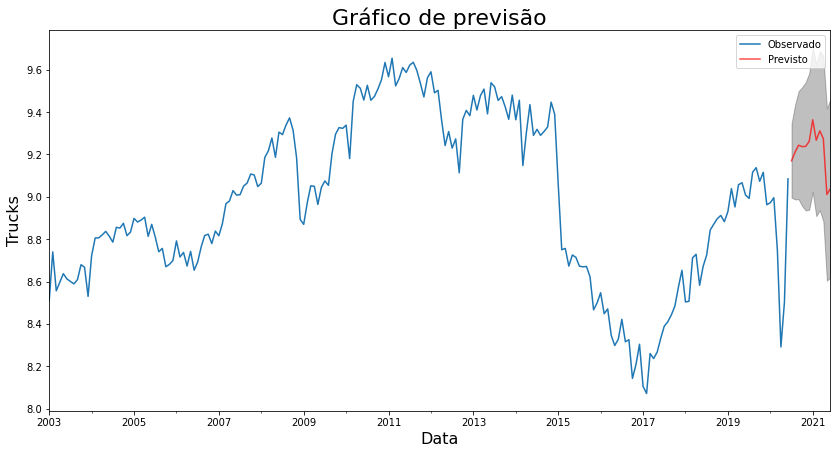

In [ ]:
pred_uc = results.get_forecast(steps = 12, exog = exog )
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observado',figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Previsto', color='r', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],color='k',alpha=0.25)
#fig = plt.plot(x,linestyle='--',color='green',label='Reais')

plt.legend()
plt.title('Gráfico de previsão', fontsize = 22)
ax.set_xlabel('Data',fontsize=16)
ax.set_ylabel('Trucks',fontsize=16)

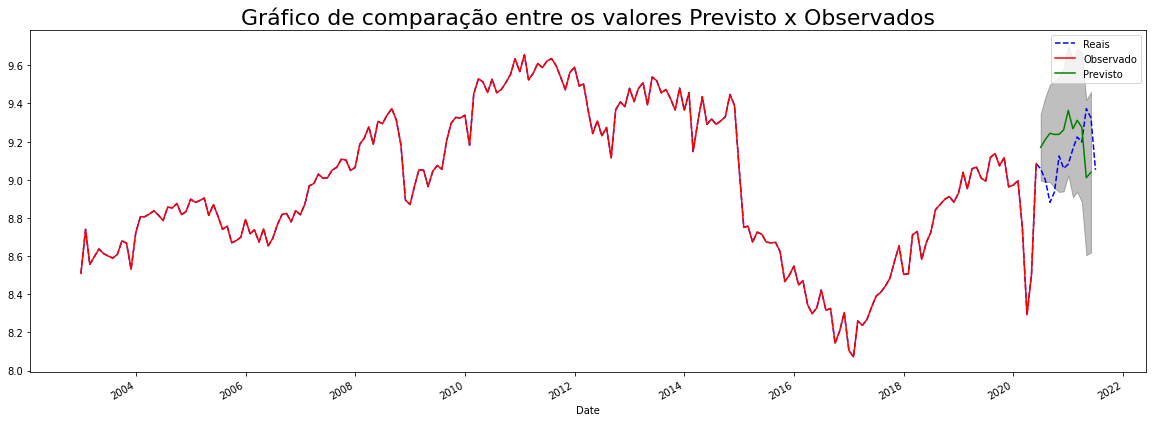

In [ ]:
x = data1['Trucks']
plt.figure(figsize=(20,7))
plt.title('Gráfico de comparação entre os valores Previsto x Observados', fontsize = 22)
fig = plt.plot(x,linestyle='--',color='b',label='Reais')
ax = y.plot(label='Observado', color='red')
pred_uc.predicted_mean.plot(ax=ax, color='green', label='Previsto')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],color='k',alpha=0.25)
plt.legend()

##Erro quadratico médio

In [ ]:
x = data1.query('Date > "2020-07-01"')
x = x['Trucks']

In [ ]:
pred = pred_uc.predicted_mean
valores_previstos = []
for z in pred:
  valores_previstos.append(z)

In [ ]:
import sklearn.metrics as metrics


In [ ]:
metrics.mean_squared_error(x, valores_previstos)

0.03934824623518007

O erro quadratico médio é de 0.039, um valor proximo de zero. Isso significa que os valores previstos são muito proximos dos valores originais.

##Métricas dos erros

In [ ]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
variance_score = metrics.explained_variance_score(x, valores_previstos)
mean_absolute_error = metrics.mean_absolute_error(x, valores_previstos)

In [ ]:
print(f'variance score = {variance_score}\nmean absolute error = {mean_absolute_error}')

variance score = -0.45977186455483143
mean absolute error = 0.1716866487751411


##Erro absoluto entre os valores reais e previstos

In [ ]:
observado_x_previsto = []
for i in range(x.size):
  observado_x_previsto.append(abs(x[i] - valores_previstos[i]))

In [ ]:
observado_x_previsto = pd.DataFrame(observado_x_previsto, columns=['Erro absoluto entre os valores reais e previstos'])

In [ ]:
observado_x_previsto

,Erro absoluto entre os valores reais e previstos
0,0.171127
1,0.329573
2,0.307100
3,0.112712
4,0.178646
5,0.179357
6,0.201398
7,0.043021
8,0.113605
9,0.098085


In [ ]:
sumx = 0
for i in x:
  sumx+=i #soma dos valores originais

sum_prev = 0
for i in valores_previstos:
  sum_prev+=i#soma dos valores previstos

erro_absoluto = sumx - sum_prev # erro absoluto do acumalado das variáveis
print(f'Soma dos valores originais: {round(sumx,2)}\nSoma dos valores previstos: {round(sum_prev, 2)}\nerro absoluto: {round(erro_absoluto, 2)}')

Soma dos valores originais: 109.42
Soma dos valores previstos: 110.63
erro absoluto: -1.21
